In [1]:
from IPython.display import clear_output

%matplotlib inline 

In [2]:
import os, sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse  
from tqdm import tqdm
import os
import gc
from src.light_sb_ou import LightSB_OU
from src.light_sb import LightSB
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from scipy.stats import chi2

# Config

In [3]:
DIM = 2  
BATCH_SIZE = 128
EPSILON = 0.1
D_LR = 2e-3
D_GRADIENT_MAX_NORM = float("inf")
N_POTENTIALS = 20
SAMPLING_BATCH_SIZE = 128
INIT_BY_SAMPLES = True
IS_DIAGONAL = True
MAX_STEPS = 2000
OUTPUT_PATH = './gaussian_grid_results'
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
def setup_consistent_evaluation():
    EVAL_SEED = 0xBADBEEF 
    torch.manual_seed(EVAL_SEED)
    np.random.seed(EVAL_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(EVAL_SEED)

# Distribution

In [5]:
def create_target_distributions():
    grid_positions = np.linspace(-6, 6, 5)
    means = np.array([(x, y) for x in grid_positions for y in grid_positions])
    
    covs = [np.array([[0.1, 0], [0, 0.1]]) for _ in range(len(means))]
    return means, covs

target_means, target_covs = create_target_distributions()

In [6]:
class StandardNormalSampler:
    def __init__(self, dim):
        self.dim = dim
        
    def sample(self, n):
        return torch.randn(n, self.dim)
    
class GaussianGridSampler:
    def __init__(self, means, covs):
        self.means = [torch.tensor(m, dtype=torch.float32) for m in means]
        self.covs = [torch.tensor(c, dtype=torch.float32) for c in covs]
        self.n_components = len(means)
        self.dim = len(means[0])
        
    def sample(self, n):
        component = torch.randint(0, self.n_components, (n,))
        samples = torch.zeros(n, self.dim)
        for i in range(n):
            c = component[i]
            samples[i] = torch.distributions.MultivariateNormal(
                self.means[c], 
                covariance_matrix=self.covs[c]
            ).sample()
        return samples

X_sampler = StandardNormalSampler(DIM)
Y_sampler = GaussianGridSampler(target_means, target_covs)

In [7]:
def plot_distributions(source_samples, target_samples, transformed_samples=None, color_v="tab:orange", title="A",
                        filename=None, traj=False):
    plt.figure(figsize=(10, 10))
    
    plt.scatter(target_samples[:, 0], target_samples[:, 1], color='g',
                alpha=0.3, label='Target (Gaussian Mixture)')
    
    if transformed_samples is not None:
        plt.scatter(transformed_samples[:, 0], transformed_samples[:, 1], color=color_v,
                    alpha=0.3, label='Transformed')
    
    for mean in target_means:
        plt.plot(mean[0], mean[1], 'ro', markersize=8)
    
    plt.legend()
    plt.grid(True)
    plt.title(title)
    
    if filename:
        plt.savefig(os.path.join(OUTPUT_PATH, filename))
        plt.close()
    else:
        pass

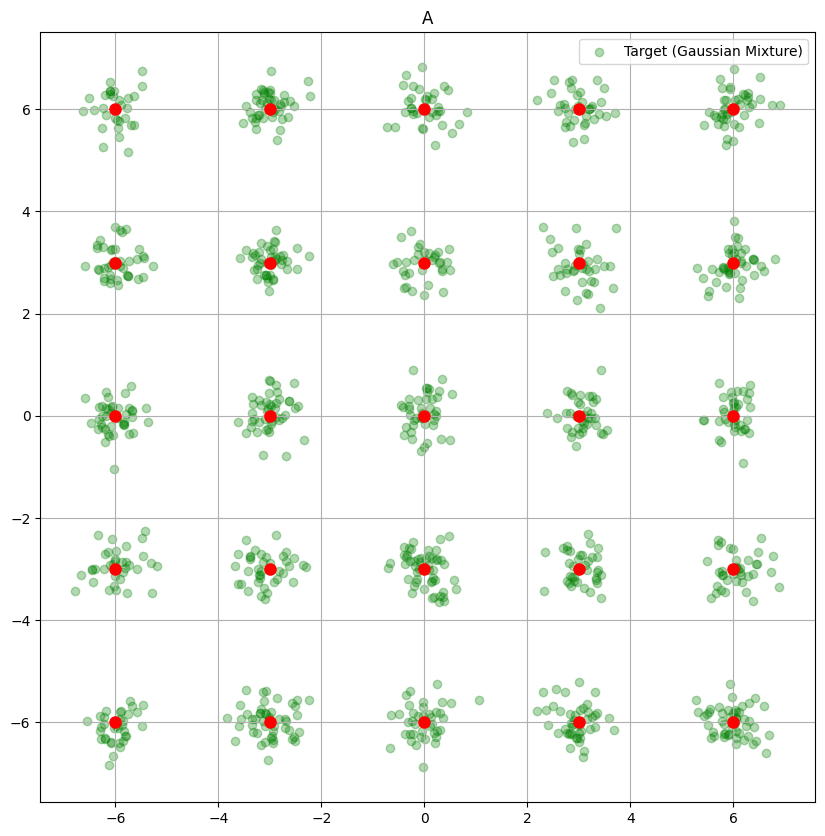

In [8]:
setup_consistent_evaluation()

plot_distributions(
    X_sampler.sample(1000).numpy(),
    Y_sampler.sample(1000).numpy(),
)

# Training

In [9]:
def train_OU_model(b, mu):
    D = LightSB_OU(
        dim=DIM, 
        n_potentials=N_POTENTIALS, 
        epsilon=EPSILON, 
        b=b, 
        m=mu,
        sampling_batch_size=SAMPLING_BATCH_SIZE, 
        S_diagonal_init=0.1,
        is_diagonal=IS_DIAGONAL
    )

    X_sampler = StandardNormalSampler(DIM)
    Y_sampler = GaussianGridSampler(target_means, target_covs)

    if INIT_BY_SAMPLES:
        D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
        
    D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)

    loss_history = []
    grad_norm_history = []
    
    for step in range(MAX_STEPS):
        D_opt.zero_grad()
        
        X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
        
        log_potential = D.get_log_potential(X1)
        log_C = D.get_log_C(X0)
        
        D_loss = (-log_potential + log_C).mean()
        D_loss.backward()
        D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
        D_opt.step()
        
        loss_history.append(D_loss.item())
        grad_norm_history.append(D_gradient_norm.item())
    
    return D, loss_history, grad_norm_history

In [10]:
def train_basic_model():
    basic_D = LightSB(
        dim=DIM, 
        n_potentials=N_POTENTIALS, 
        epsilon=EPSILON, 
        sampling_batch_size=SAMPLING_BATCH_SIZE, 
        S_diagonal_init=0.1,
        is_diagonal=IS_DIAGONAL
    )

    X_sampler = StandardNormalSampler(DIM)
    Y_sampler = GaussianGridSampler(target_means, target_covs)

    if INIT_BY_SAMPLES:
        basic_D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
        
    basic_D_opt = torch.optim.Adam(basic_D.parameters(), lr=D_LR)

    loss_history = []
    grad_norm_history = []
    
    for step in range(MAX_STEPS):
        basic_D_opt.zero_grad()
        
        X0, X1 = X_sampler.sample(BATCH_SIZE), Y_sampler.sample(BATCH_SIZE)
        
        log_potential = basic_D.get_log_potential(X1)
        log_C = basic_D.get_log_C(X0)
        
        D_loss = (-log_potential + log_C).mean()
        D_loss.backward()
        D_gradient_norm = torch.nn.utils.clip_grad_norm_(basic_D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
        basic_D_opt.step()
        
        loss_history.append(D_loss.item())
        grad_norm_history.append(D_gradient_norm.item())
    
    return basic_D, loss_history, grad_norm_history

# Metrics

In [11]:
def sliced_wasserstein_distance(X, Y, n_projections=100):
    dim = X.shape[1]
    projections = torch.randn(dim, n_projections)
    projections /= torch.norm(projections, dim=0, keepdim=True)
    
    X_projections = X @ projections
    Y_projections = Y @ projections
    
    X_projections_sorted = torch.sort(X_projections, dim=0)[0]
    Y_projections_sorted = torch.sort(Y_projections, dim=0)[0]
    
    return torch.mean(torch.abs(X_projections_sorted - Y_projections_sorted))

def compute_mmd(X, Y, gamma=None):
    if gamma is None:
        XX = torch.cdist(X, X)**2
        YY = torch.cdist(Y, Y)**2
        XY = torch.cdist(X, Y)**2
        median_dist = torch.median(torch.cat([XX.view(-1), YY.view(-1), XY.view(-1)]))
        gamma = 1.0 / (2.0 * median_dist)
    
    XX = torch.exp(-gamma * torch.cdist(X, X)**2)
    YY = torch.exp(-gamma * torch.cdist(Y, Y)**2)
    XY = torch.exp(-gamma * torch.cdist(X, Y)**2)
    
    m = X.shape[0]
    n = Y.shape[0]
    
    return (XX.sum() / (m*(m-1)) + 
            YY.sum() / (n*(n-1)) - 
            2 * XY.sum() / (m*n))

def energy_distance(X, Y):
    XX = torch.cdist(X, X).mean()
    YY = torch.cdist(Y, Y).mean()
    XY = torch.cdist(X, Y).mean()
    return 2*XY - XX - YY

def count_covered_modes(samples, target_means, target_covs, confidence=0.9):
    covered = []
    n_covered = 0
    
    critical_value = chi2.ppf(confidence, df=2)
    
    for mean, cov in zip(target_means, target_covs):
        diff = samples - mean
        inv_cov = np.linalg.inv(cov)
        mahal_sq = np.sum(diff @ inv_cov * diff, axis=1)
        
        is_covered = np.any(mahal_sq <= critical_value)
        covered.append(is_covered)
        n_covered += int(is_covered)
    
    return n_covered, covered

# LightSB-OU evaluation

In [12]:
n_p_b_mu = [[-0.15981803361039648, -0.04072560679456577], [-0.13904333457719592, -0.3267941094348268],
                    [-0.11354125044453148, -0.17311976511784927], [-0.09884917697044152, -0.2248115918720785]]

In [13]:
def evaluate_n_potentials(n_potentials_list, n_runs=5):
    results = []
    results_b_mu = []
    i = 0
    for n_p in n_potentials_list:
        print(f"Evaluating N_POTENTIALS={n_p}")
        metrics = {'n_potentials': n_p, 'swd': [], 'mmd': [],
                   'modes': [], 'energy': []}

        global N_POTENTIALS
        N_POTENTIALS = n_p
        
        b, mu = n_p_b_mu[i][0], n_p_b_mu[i][1]

        setup_consistent_evaluation()

        X_sampler = StandardNormalSampler(DIM)
        Y_sampler = GaussianGridSampler(target_means, target_covs)

        model, loss_history, grad_history = train_OU_model(float(b), float(mu))
        
        for _ in range(n_runs):
            test_samples = X_sampler.sample(10000)
            transformed = model(test_samples).numpy()
            target_samples = Y_sampler.sample(10000).numpy()
            
            swd = sliced_wasserstein_distance(torch.tensor(transformed), torch.tensor(target_samples)).item()
            mmd = compute_mmd(torch.tensor(transformed), torch.tensor(target_samples)).item()
            n_covered, _ = count_covered_modes(transformed, target_means, target_covs)

            energy = energy_distance(torch.tensor(transformed), torch.tensor(target_samples)).item()
            
            metrics['swd'].append(swd)
            metrics['mmd'].append(mmd)
            metrics['modes'].append(n_covered)
            metrics['energy'].append(energy)
        
        metrics['swd'] = [np.mean(metrics['swd']), np.std(metrics['swd'])]
        metrics['mmd'] = [np.mean(metrics['mmd']), np.std(metrics['mmd'])]
        metrics['modes'] = [np.mean(metrics['modes']), np.std(metrics['modes'])]
        metrics['energy'] = [np.mean(metrics['energy']), np.std(metrics['energy'])]
        results.append(metrics)
        
        i += 1
    
    return results

# Run evaluation
n_potentials_list = [15, 20, 25, 30]
results_n_p = evaluate_n_potentials(n_potentials_list)

Evaluating N_POTENTIALS=15
Evaluating N_POTENTIALS=20
Evaluating N_POTENTIALS=25
Evaluating N_POTENTIALS=30


In [14]:
results_n_p

[{'n_potentials': 15,
  'swd': [0.46266855001449586, 0.014776404348131244],
  'mmd': [0.0018831729888916016, 0.0002357657835583114],
  'modes': [21.8, 0.7483314773547883],
  'energy': [0.07293691635131835, 0.003636816435350978]},
 {'n_potentials': 20,
  'swd': [0.32558172941207886, 0.008715562379055327],
  'mmd': [0.00032110214233398436, 7.076183900874652e-05],
  'modes': [19.8, 0.9797958971132713],
  'energy': [0.0366511344909668, 0.0014859071569061375]},
 {'n_potentials': 25,
  'swd': [0.310393226146698, 0.009663599582513713],
  'mmd': [0.0006949901580810547, 0.00020229596562221894],
  'modes': [21.0, 0.6324555320336759],
  'energy': [0.03310098648071289, 0.002749966126065353]},
 {'n_potentials': 30,
  'swd': [0.13664477169513703, 0.021509620961043474],
  'mmd': [0.0003366708755493164, 0.0001458061953828466],
  'modes': [25.0, 0.0],
  'energy': [0.006040191650390625, 0.001919660656336492]}]

# Plots with std

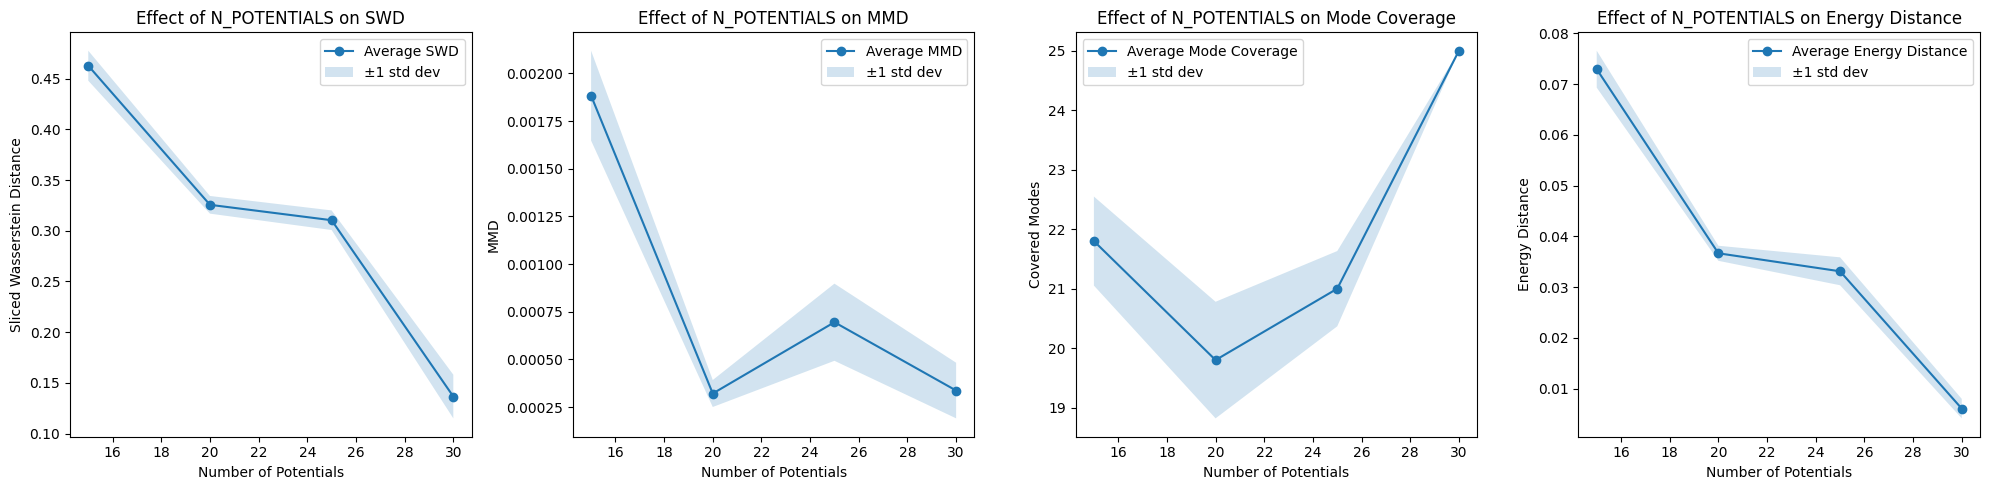

In [15]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
x_values = [r['n_potentials'] for r in results_n_p]
y_avg = [r['swd'][0] for r in results_n_p]
y_std = [r['swd'][1] for r in results_n_p]  
plt.plot(x_values, y_avg, 'o-', label='Average SWD')
plt.fill_between(x_values, 
                 [avg - std for avg, std in zip(y_avg, y_std)], 
                 [avg + std for avg, std in zip(y_avg, y_std)], 
                 alpha=0.2, label='±1 std dev')
plt.xlabel('Number of Potentials')
plt.ylabel('Sliced Wasserstein Distance')
plt.title('Effect of N_POTENTIALS on SWD')
plt.legend()  

plt.subplot(1, 4, 2)
x_values = [r['n_potentials'] for r in results_n_p]
y_avg = [r['mmd'][0] for r in results_n_p]
y_std = [r['mmd'][1] for r in results_n_p]  
plt.plot(x_values, y_avg, 'o-', label='Average MMD')
plt.fill_between(x_values, 
                 [avg - std for avg, std in zip(y_avg, y_std)], 
                 [avg + std for avg, std in zip(y_avg, y_std)], 
                 alpha=0.2, label='±1 std dev')
plt.xlabel('Number of Potentials')
plt.ylabel('MMD')
plt.title('Effect of N_POTENTIALS on MMD')
plt.legend()  

plt.subplot(1, 4, 3)
x_values = [r['n_potentials'] for r in results_n_p]
y_avg = [r['modes'][0] for r in results_n_p]
y_std = [r['modes'][1] for r in results_n_p]  
plt.plot(x_values, y_avg, 'o-', label='Average Mode Coverage')
plt.fill_between(x_values, 
                 [avg - std for avg, std in zip(y_avg, y_std)], 
                 [avg + std for avg, std in zip(y_avg, y_std)], 
                 alpha=0.2, label='±1 std dev')
plt.xlabel('Number of Potentials')
plt.ylabel('Covered Modes')
plt.title('Effect of N_POTENTIALS on Mode Coverage')
plt.legend()  

plt.subplot(1, 4, 4)
x_values = [r['n_potentials'] for r in results_n_p]
y_avg = [r['energy'][0] for r in results_n_p]
y_std = [r['energy'][1] for r in results_n_p]  
plt.plot(x_values, y_avg, 'o-', label='Average Energy Distance')
plt.fill_between(x_values, 
                 [avg - std for avg, std in zip(y_avg, y_std)], 
                 [avg + std for avg, std in zip(y_avg, y_std)], 
                 alpha=0.2, label='±1 std dev')
plt.xlabel('Number of Potentials')
plt.ylabel('Energy Distance')
plt.title('Effect of N_POTENTIALS on Energy Distance')
plt.legend()  

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'standard_n_potentials_analysis.png'))
plt.show()

# LightSB evaluation

In [16]:
def evaluate_basic_n_potentials(n_potentials_list, n_runs=5):
    setup_consistent_evaluation()
    results = []
    for n_p in n_potentials_list:
        print(f"Evaluating N_POTENTIALS={n_p}")
        metrics = {'n_potentials': n_p, 'swd': [], 'mmd': [],
                   'modes': [], 'energy': []}

        global N_POTENTIALS
        N_POTENTIALS = n_p

        X_sampler = StandardNormalSampler(DIM)
        Y_sampler = GaussianGridSampler(target_means, target_covs)
        
        model, loss_history, grad_history = train_basic_model()
        
        for _ in range(n_runs):
            test_samples = X_sampler.sample(10000)
            transformed = model(test_samples).numpy()
            target_samples = Y_sampler.sample(10000).numpy()
            
            swd = sliced_wasserstein_distance(torch.tensor(transformed), torch.tensor(target_samples)).item()
            mmd = compute_mmd(torch.tensor(transformed), torch.tensor(target_samples)).item()
            n_covered, _ = count_covered_modes(transformed, target_means, target_covs)

            energy = energy_distance(torch.tensor(transformed), torch.tensor(target_samples)).item()
            
            metrics['swd'].append(swd)
            metrics['mmd'].append(mmd)
            metrics['modes'].append(n_covered)
            metrics['energy'].append(energy)
        
        metrics['swd'] = [np.mean(metrics['swd']), np.std(metrics['swd'])]
        metrics['mmd'] = [np.mean(metrics['mmd']), np.std(metrics['mmd'])]
        metrics['modes'] = [np.mean(metrics['modes']), np.std(metrics['modes'])]
        metrics['energy'] = [np.mean(metrics['energy']), np.std(metrics['energy'])]
        results.append(metrics)
    
    return results

results_basic_n_p = evaluate_basic_n_potentials(n_potentials_list)

Evaluating N_POTENTIALS=15
Evaluating N_POTENTIALS=20
Evaluating N_POTENTIALS=25
Evaluating N_POTENTIALS=30


In [17]:
results_basic_n_p

[{'n_potentials': 15,
  'swd': [0.4975902199745178, 0.022031441761648278],
  'mmd': [0.0017574548721313477, 0.0003076271013429703],
  'modes': [20.8, 0.39999999999999997],
  'energy': [0.07984819412231445, 0.00518748164683397]},
 {'n_potentials': 20,
  'swd': [0.3996453583240509, 0.022411044196593295],
  'mmd': [0.000753474235534668, 0.00025927049355571797],
  'modes': [22.4, 0.4898979485566356],
  'energy': [0.04622840881347656, 0.004153494789460693]},
 {'n_potentials': 25,
  'swd': [0.32044782638549807, 0.006376809951903861],
  'mmd': [0.0007102251052856446, 0.00011070019821764181],
  'modes': [22.4, 0.4898979485566356],
  'energy': [0.03681249618530273, 0.0018189945417656712]},
 {'n_potentials': 30,
  'swd': [0.25982028543949126, 0.01586314841648889],
  'mmd': [0.000400543212890625, 0.00011372048888045798],
  'modes': [24.2, 0.4],
  'energy': [0.023239994049072267, 0.0020741005641274376]}]

# Comparative plots

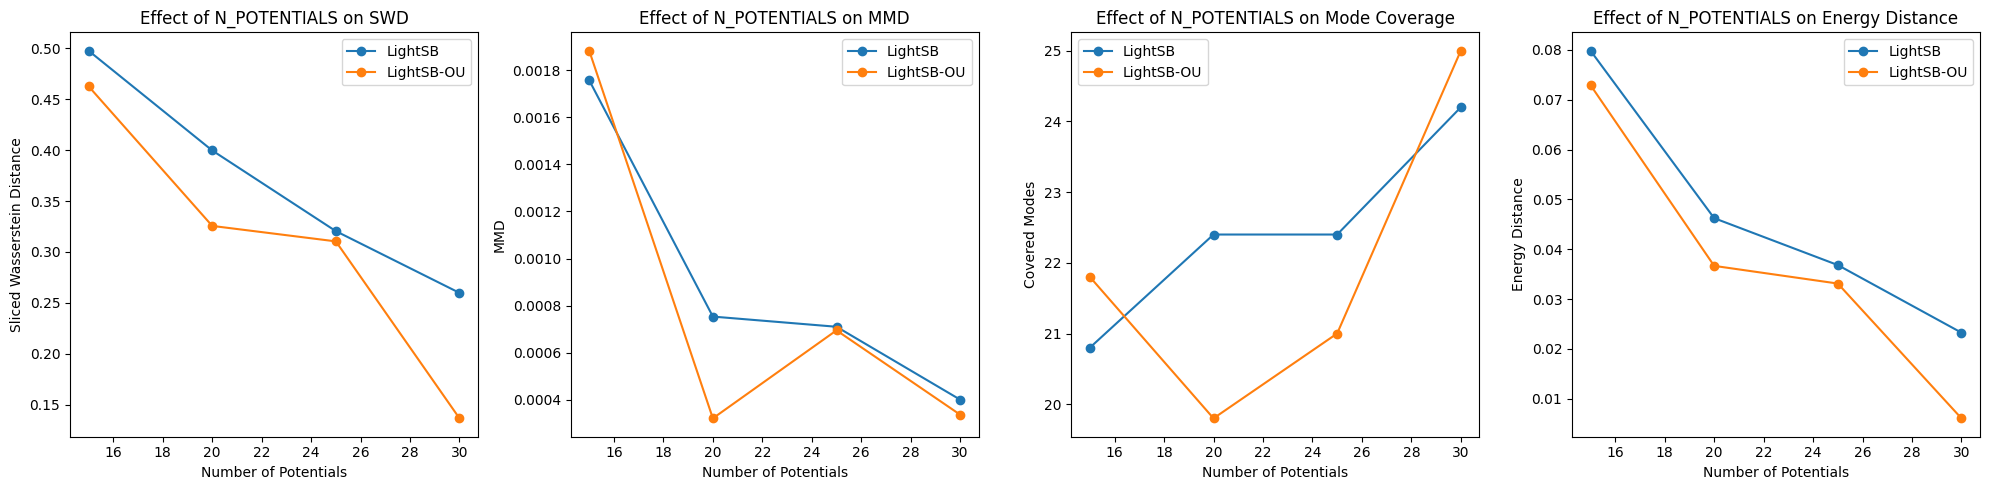

In [18]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot([r['n_potentials'] for r in results_basic_n_p], [r['swd'][0] for r in results_basic_n_p], 'o-')
plt.plot([r['n_potentials'] for r in results_n_p], [r['swd'][0] for r in results_n_p], 'o-')
plt.xlabel('Number of Potentials')
plt.ylabel('Sliced Wasserstein Distance')
plt.title('Effect of N_POTENTIALS on SWD')
plt.legend(['LightSB', 'LightSB-OU']) 

plt.subplot(1, 4, 2)
plt.plot([r['n_potentials'] for r in results_basic_n_p], [r['mmd'][0] for r in results_basic_n_p], 'o-')
plt.plot([r['n_potentials'] for r in results_n_p], [r['mmd'][0] for r in results_n_p], 'o-')
plt.xlabel('Number of Potentials')
plt.ylabel('MMD')
plt.title('Effect of N_POTENTIALS on MMD')
plt.legend(['LightSB', 'LightSB-OU']) 

plt.subplot(1, 4, 3)
plt.plot([r['n_potentials'] for r in results_basic_n_p], [r['modes'][0] for r in results_basic_n_p], 'o-')
plt.plot([r['n_potentials'] for r in results_n_p], [r['modes'][0] for r in results_n_p], 'o-')
plt.xlabel('Number of Potentials')
plt.ylabel('Covered Modes')
plt.title('Effect of N_POTENTIALS on Mode Coverage')
plt.legend(['LightSB', 'LightSB-OU']) 

plt.subplot(1, 4, 4)
plt.plot([r['n_potentials'] for r in results_basic_n_p], [r['energy'][0] for r in results_basic_n_p], 'o-')
plt.plot([r['n_potentials'] for r in results_n_p], [r['energy'][0] for r in results_n_p], 'o-')
plt.xlabel('Number of Potentials')
plt.ylabel('Energy Distance')
plt.title('Effect of N_POTENTIALS on Energy Distance')
plt.legend(['LightSB', 'LightSB-OU']) 

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'standard_two_n_potentials_analysis.png'))
plt.show()

# Examples of generation

In [19]:
N_POTENTIALS = 25
setup_consistent_evaluation()
model, loss_history, grad_history = train_OU_model(n_p_b_mu[2][0], n_p_b_mu[2][1])

In [20]:
model.eval()
X_sampler = StandardNormalSampler(DIM)
Y_sampler = GaussianGridSampler(target_means, target_covs)

with torch.no_grad():
    source_samples = X_sampler.sample(10000)
    target_samples = Y_sampler.sample(10000)

    transformed = model(source_samples)
    plot_distributions(
        source_samples.numpy(),
        Y_sampler.sample(10000).numpy(),
        transformed.numpy(),
        title="LightSB-OU Results for Standard Case",
        filename="standard_ou_25"
    )

In [21]:
setup_consistent_evaluation()
b_model, loss_history, grad_history = train_basic_model()

In [22]:
b_model.eval()
X_sampler = StandardNormalSampler(DIM)
Y_sampler = GaussianGridSampler(target_means, target_covs)

with torch.no_grad():
    source_samples = X_sampler.sample(10000)
    target_samples = Y_sampler.sample(10000)

    transformed = b_model(source_samples)
    plot_distributions(
        source_samples.numpy(),
        Y_sampler.sample(10000).numpy(),
        transformed.numpy(),
        color_v='tab:blue',
        title="LightSB Results for Standard Case",
        filename="standard_basic_25"
    )